# **Important Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

2025-07-11 13:31:55.928057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752240716.107456      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752240716.163689      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Prepare Data**

In [2]:
def create_dataset(data_dir):
  filepaths = []
  labels = []
  folds = os.listdir(data_dir)
  for fold in folds:
    foldpath = os.path.join(data_dir,fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
      filepath = os.path.join(foldpath, file)
      filepaths.append(filepath)
      labels.append(fold)
  return pd.DataFrame({"Images":filepaths,"labels":labels})

In [3]:
train_data_dir = "/kaggle/input/teeth-disease/Teeth_DataSet/Teeth_Dataset/Training"
train = create_dataset(train_data_dir)
print(train.shape)
train.head()

(3087, 2)


,Images,labels
0,/kaggle/input/teeth-disease/Teeth_DataSet/Teet...,OC
1,/kaggle/input/teeth-disease/Teeth_DataSet/Teet...,OC
2,/kaggle/input/teeth-disease/Teeth_DataSet/Teet...,OC
3,/kaggle/input/teeth-disease/Teeth_DataSet/Teet...,OC
4,/kaggle/input/teeth-disease/Teeth_DataSet/Teet...,OC


In [4]:
test_data_dir = "/kaggle/input/teeth-disease/Teeth_DataSet/Teeth_Dataset/Testing"
test = create_dataset(test_data_dir)
print(test.shape)
test.head()

(1028, 2)


,Images,labels
0,/kaggle/input/teeth-disease/Teeth_DataSet/Teet...,OC
1,/kaggle/input/teeth-disease/Teeth_DataSet/Teet...,OC
2,/kaggle/input/teeth-disease/Teeth_DataSet/Teet...,OC
3,/kaggle/input/teeth-disease/Teeth_DataSet/Teet...,OC
4,/kaggle/input/teeth-disease/Teeth_DataSet/Teet...,OC


In [5]:
valid_data_dir = "/kaggle/input/teeth-disease/Teeth_DataSet/Teeth_Dataset/Validation"
valid = create_dataset(valid_data_dir)
print(valid.shape)
valid.head()

(1028, 2)


,Images,labels
0,/kaggle/input/teeth-disease/Teeth_DataSet/Teet...,OC
1,/kaggle/input/teeth-disease/Teeth_DataSet/Teet...,OC
2,/kaggle/input/teeth-disease/Teeth_DataSet/Teet...,OC
3,/kaggle/input/teeth-disease/Teeth_DataSet/Teet...,OC
4,/kaggle/input/teeth-disease/Teeth_DataSet/Teet...,OC


# **Image Data Generator**

In [6]:
batch_size = 32
img_size = (224, 224)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.2, 1.2])
test_gen = ImageDataGenerator()

train_gen = train_gen.flow_from_dataframe(
    train,
    x_col= 'Images',
    y_col= 'labels', target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle = True,
    batch_size= batch_size
)

valid_gen = test_gen.flow_from_dataframe(
    valid,
    x_col= 'Images',
    y_col= 'labels',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle = False,
    batch_size= batch_size
)

test_gen = test_gen.flow_from_dataframe(
    test,
    x_col= 'Images',
    y_col= 'labels',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle = False,
    batch_size= batch_size
)

Found 3087 validated image filenames belonging to 7 classes.
Found 1028 validated image filenames belonging to 7 classes.
Found 1028 validated image filenames belonging to 7 classes.


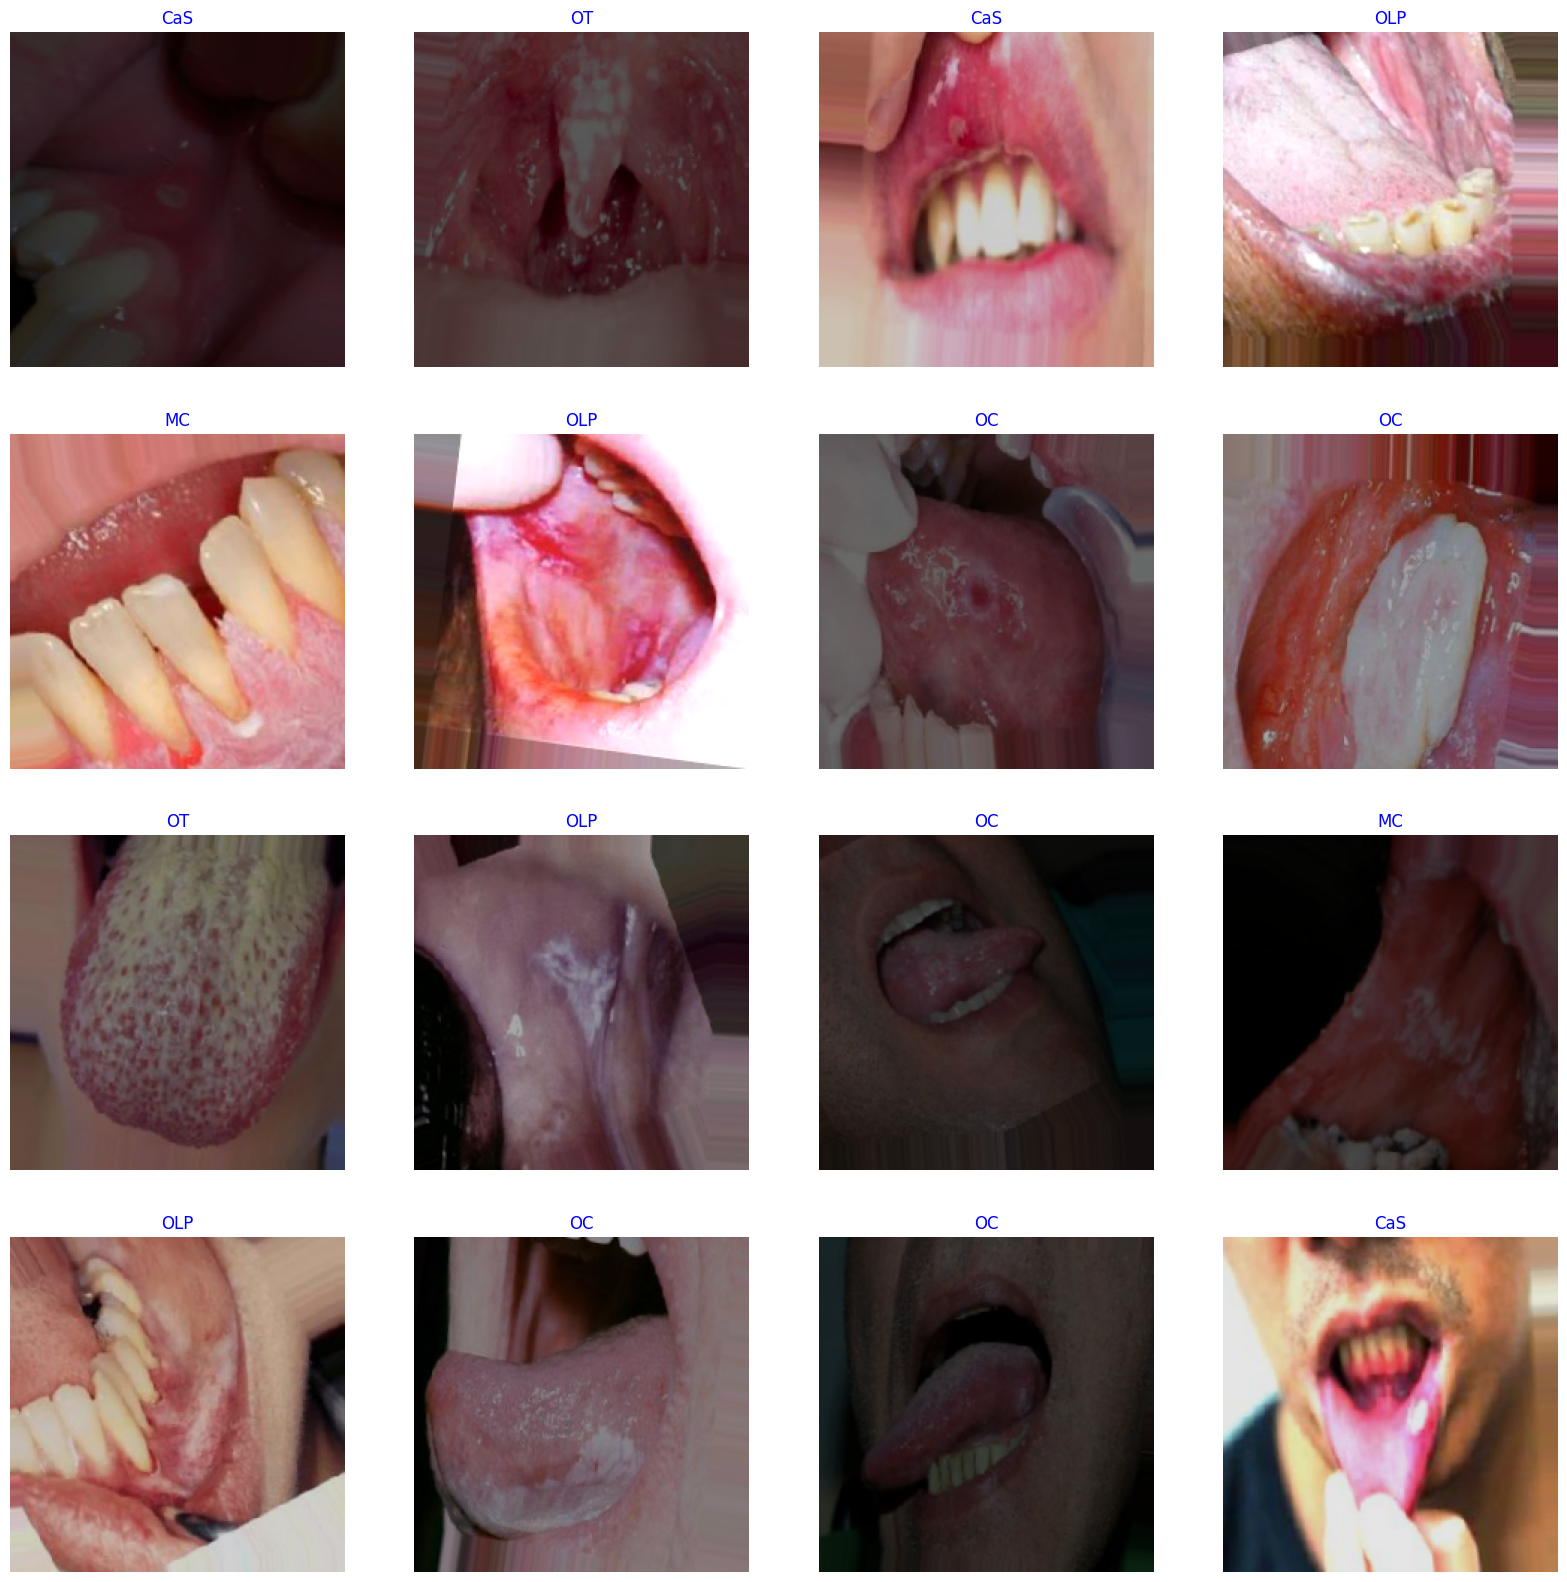

In [ ]:
g_dict = train_gen.class_indices   
classes = list(g_dict.keys())
images, labels = next(train_gen)     

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255 
    plt.imshow(image)
    index = np.argmax(labels[i]) 
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model**

In [8]:
channels = 3
img_shape = (img_size[0],img_size[1],channels)
class_count = len(list(train_gen.class_indices.keys()))

In [9]:
# Load EfficientNetB3 pre-trained on ImageNet
base_model = EfficientNetB3(
    weights = "imagenet",
    include_top = False,
    input_shape = img_shape,
)

base_model.summary()

I0000 00:00:1752240739.222682      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 10,696,232 (40.80 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [10]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.3),
    Dense(class_count,activation='softmax')
])

model.compile(
    Adamax(learning_rate= 0.001),
    loss= 'categorical_crossentropy',
    metrics= ['accuracy']
    )

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 75264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    19,267,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,053,174 (114.64 MB)

 Trainable params: 29,965,871 (114.31 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [11]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_model.h5',
                                   monitor='val_accuracy',
                                   save_best_only=True)

history=model.fit(train_gen,
                  epochs=50,
                  batch_size = batch_size,
                  validation_data=valid_gen,
                  callbacks=[early_stopping,model_checkpoint])

Epoch 1/50


I0000 00:00:1752240822.646873     101 service.cc:148] XLA service 0x7efcb4002c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752240822.647765     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752240829.393097     101 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1752240842.336375     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752240842.533101     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752240843.076007     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752240843.2946

14/97 ━━━━━━━━━━━━━━━━━━━━ 38s 468ms/step - accuracy: 0.2661 - loss: 4.0563

E0000 00:00:1752240898.409131      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752240898.604186      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752240898.798771      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752240899.273621      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752240899.490781      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

97/97 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.4895 - loss: 2.1043 - val_accuracy: 0.8366 - val_loss: 0.4671
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 451ms/step - accuracy: 0.8712 - loss: 0.3608 - val_accuracy: 0.9757 - val_loss: 0.0799
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 453ms/step - accuracy: 0.9502 - loss: 0.1564 - val_accuracy: 0.9874 - val_loss: 0.0381
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 462ms/step - accuracy: 0.9744 - loss: 0.0938 - val_accuracy: 0.9912 - val_loss: 0.0334
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 46s 468ms/step - accuracy: 0.9751 - loss: 0.0767 - val_accuracy: 0.9932 - val_loss: 0.0219
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 46s 471ms/step - accuracy: 0.9798 - loss: 0.0740 - val_accuracy: 0.9951 - val_loss: 0.0173
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 439ms/step - accuracy: 0.9798 - loss: 0.0598 - val_accuracy: 0.9942 - val_loss: 0.0157
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 448ms/step - accuracy: 0.9780 - loss: 0.0532 - val_accuracy: 0.9912 

# **Evaluation**

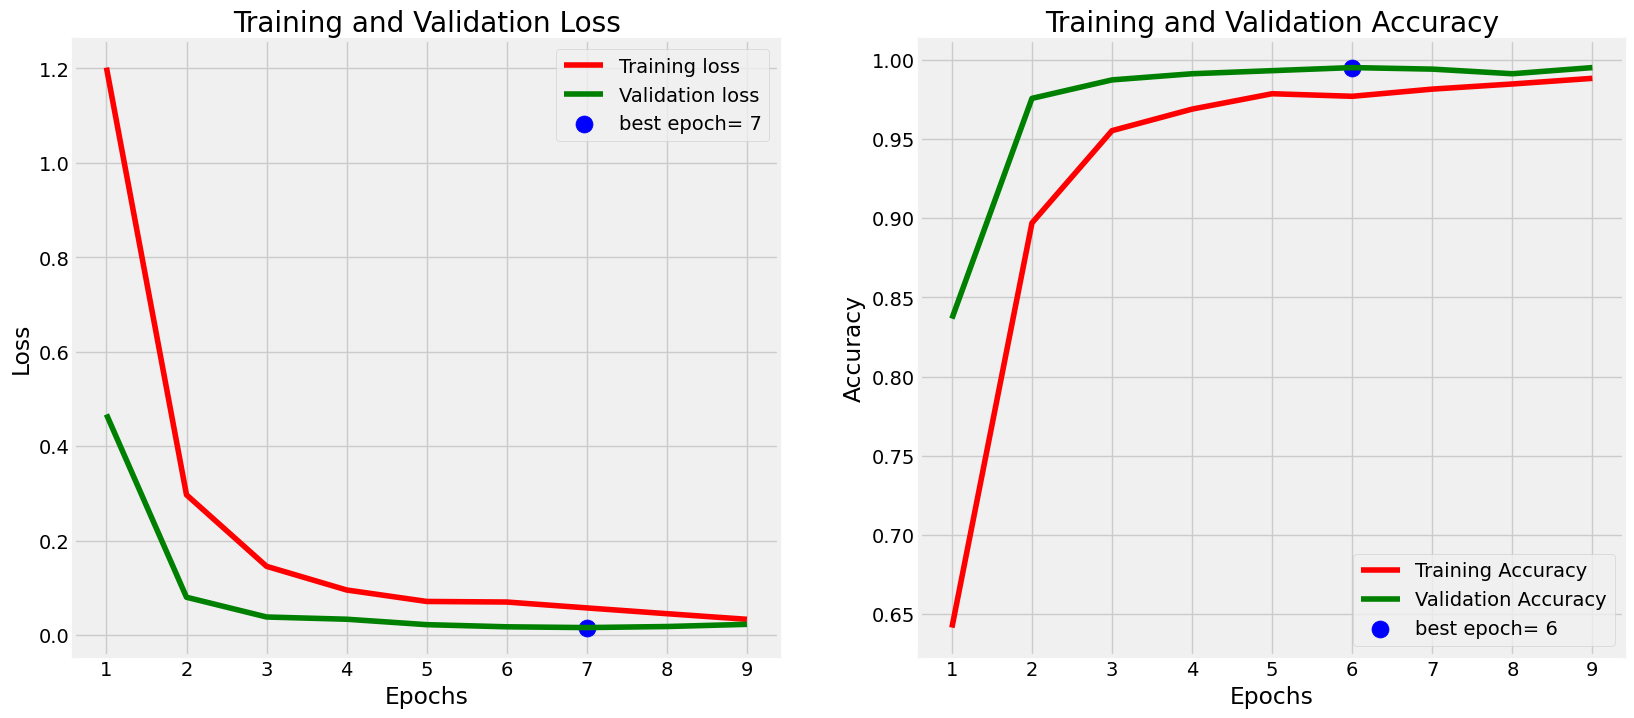

In [12]:
# Plot Accuracy and Loss
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [13]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 441ms/step - accuracy: 0.9950 - loss: 0.0110
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9934 - loss: 0.0159
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9903 - loss: 0.0251
Train Loss:  0.011516033671796322
Train Accuracy:  0.9951409101486206
--------------------
Validation Loss:  0.017332684248685837
Validation Accuracy:  0.9951362013816833
--------------------
Test Loss:  0.02730807103216648
Test Accuracy:  0.9902724027633667


In [14]:
# Get Predictions
preds = model.predict(test_gen) 
y_pred = np.argmax(preds, axis=1) 
g_dict = test_gen.class_indices 
classes = list(g_dict.keys())

33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 388ms/step


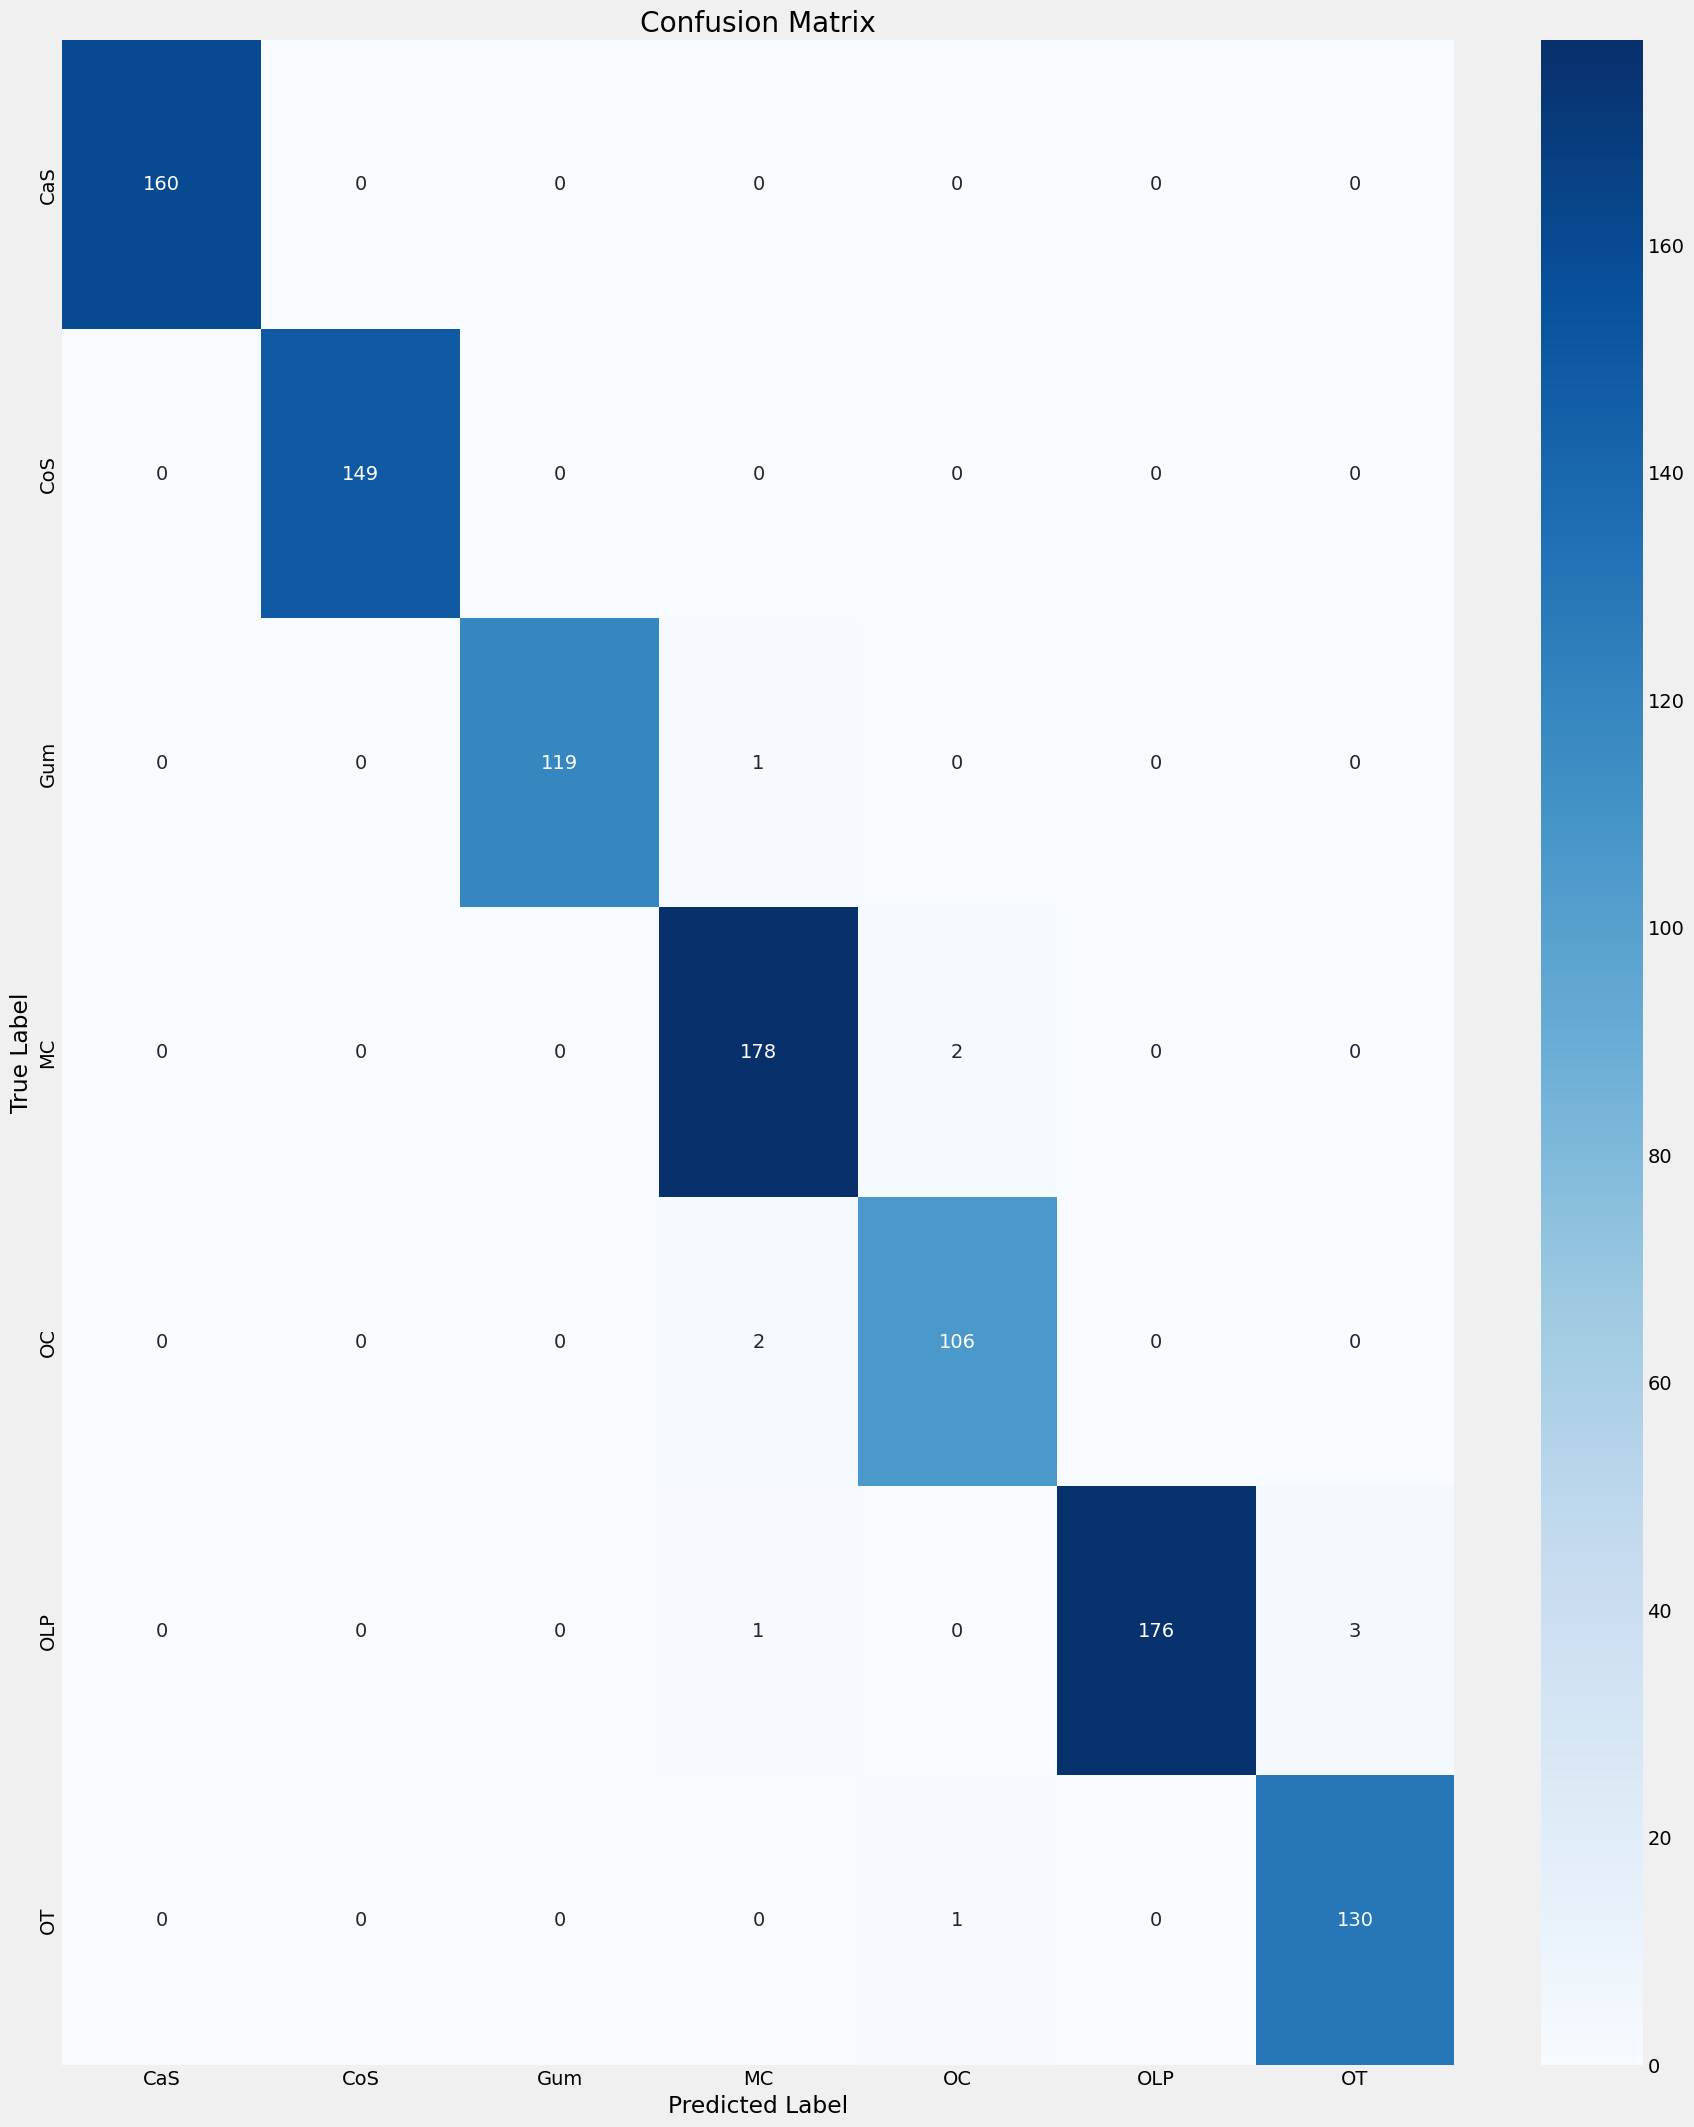

In [15]:
# Confusion Matrix
plt.figure(figsize=(20, 25))
cm = confusion_matrix(test_gen.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [16]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

         CaS       1.00      1.00      1.00       160
         CoS       1.00      1.00      1.00       149
         Gum       1.00      0.99      1.00       120
          MC       0.98      0.99      0.98       180
          OC       0.97      0.98      0.98       108
         OLP       1.00      0.98      0.99       180
          OT       0.98      0.99      0.98       131

    accuracy                           0.99      1028
   macro avg       0.99      0.99      0.99      1028
weighted avg       0.99      0.99      0.99      1028

